In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./../..")

# standard lib
import shutil
from pathlib import Path

# external imports
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import scipy as sp
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

# local imports
from datasets import AffNIST
from effcn.layers import SquashHinton, CapsLayer
from effcn.functions import margin_loss, masking
from misc.utils import count_parameters
from misc.plot_utils import plot_couplings, plot_capsules, plot_mat, plot_mat2
from misc.metrics import *

In [3]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)

# Data

In [4]:
transform_train = T.Compose([
    T.RandomAffine(degrees=(-8, 8),
                   shear=(-15, 15),
                   scale=(0.9, 1.1)
                  ),
    T.Normalize((0.0641,), (0.2257))
])
transform_valid = T.Normalize((0.0641,), (0.2257))

#p_data = '/home/matthias/projects/EfficientCN/data'
p_data = Path("C:\\Users\\matth\\projects\\EfficientCN\\data")

ds_mnist_train = AffNIST(p_root=p_data, split="mnist_train", download=True, transform=transform_train, target_transform=None)
ds_mnist_valid = AffNIST(p_root=p_data, split="mnist_valid", download=True, transform=transform_valid, target_transform=None)
ds_affnist_valid = AffNIST(p_root=p_data, split="affnist_valid", download=True, transform=transform_valid, target_transform=None)

In [5]:
bs = 128
dl_mnist_train = torch.utils.data.DataLoader(
    ds_mnist_train, 
    batch_size=bs, 
    shuffle=True,
    pin_memory=True,
    num_workers=4)
dl_mnist_valid= torch.utils.data.DataLoader(
    ds_mnist_valid, 
    batch_size=bs, 
    shuffle=True, 
    pin_memory=True,
    num_workers=4)
dl_affnist_valid= torch.utils.data.DataLoader(
    ds_affnist_valid, 
    batch_size=bs, 
    shuffle=True, 
    pin_memory=True,
    num_workers=4)

In [6]:
x, _ = next(iter(dl_mnist_train))
x_vis_train = x[:32]

x, _ = next(iter(dl_mnist_valid))
x_vis_mnist_valid = x[:32]

x, _ = next(iter(dl_affnist_valid))
x_vis_affnist_valid = x[:32]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


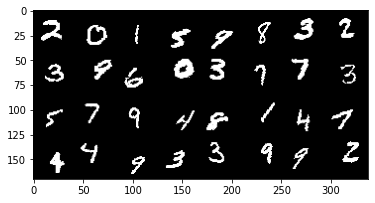

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


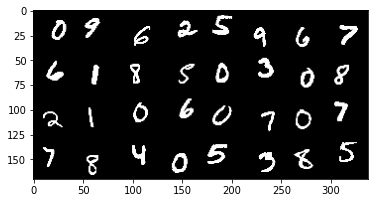

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


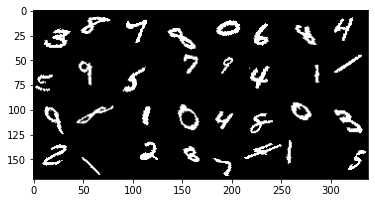

In [7]:
plt.imshow(torchvision.utils.make_grid(x_vis_train).permute(1,2,0))
plt.show()
#
plt.imshow(torchvision.utils.make_grid(x_vis_mnist_valid).permute(1,2,0))
plt.show()
#
plt.imshow(torchvision.utils.make_grid(x_vis_affnist_valid).permute(1,2,0))
plt.show()

# Models

### Backbone

In [43]:
class Backbone(nn.Module):
    """
        Backbone model for AffNIST (40x40)
    """

    def __init__(self, ch_in=1, ch_out=128, n_classes=10):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(ch_in, 32, kernel_size=(5, 5), padding="valid"),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding="valid"),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding="valid"),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, ch_out, kernel_size=(3, 3), stride=2, padding="valid"),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(ch_out),
            nn.Conv2d(ch_out, ch_out, kernel_size=(15,15), groups=ch_out)
        )
        self.fc = nn.Linear(ch_out , n_classes)

    def forward(self, x):
        """
            IN:
                x (b, 1, 40, 40)
            OUT:
                x (b, 128, 15, 15)
        """
        x = self.layers(x)
        x = torch.flatten(x, 1)     # -> (b, 256), remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)
        return x

In [44]:
# Check if it works
model = Backbone(ch_in=1, ch_out=256, n_classes=10)
model.fc = torch.nn.Identity()
y = model(torch.rand(1, 1, 40, 40))
print(count_parameters(model))
print(y.shape)

447168
torch.Size([1, 256])


### Decoder

In [45]:
class Decoder(nn.Module):
    """
        Decoder model for AffNIST (40x40)
        Except for last layer identical with MNIST Decoder
    """

    def __init__(self, d_in, d_out):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(d_in, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, d_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
            IN:
                x (b, d_in) 
            OUT:
                x_rec (b, d_out)
            Notes:
                input must be masked!
        """
        x = self.layers(x)
        return x

In [46]:
model = Decoder(d_in=32, d_out=40*40)
y=model(torch.rand(1, 32))
y.shape

torch.Size([1, 1600])

In [47]:
class AgreementRouting(nn.Module):
    def __init__(self, n_l, n_h, n_iter, sm_temp):
        super(AgreementRouting, self).__init__()
        self.n_iter = n_iter
        self.b = nn.Parameter(torch.zeros((n_l, n_h)))
        self.squash =  SquashHinton()
        self.sm_temp = sm_temp

    def forward(self, u_predict):
        v, _ = self.forward_debug(u_predict)
        return v

    def forward_debug(self, u_predict):
        batch_size, n_l, n_h, output_dim = u_predict.size()

        c = F.softmax(self.b / self.sm_temp, dim=-1)
        s = (c.unsqueeze(2) * u_predict).sum(dim=1)
        v = self.squash(s)

        if self.n_iter > 0:
            b_batch = self.b.expand((batch_size, n_l, n_h))
            for r in range(self.n_iter):
                v = v.unsqueeze(1)
                b_batch = b_batch + (u_predict * v).sum(-1)

                c = F.softmax(b_batch.view(-1, n_h) / self.sm_temp, dim=-1).view(-1, n_l, n_h, 1)
                s = (c * u_predict).sum(dim=1)
                v = self.squash(s)
        return v, c.squeeze()


class CapsLayer(nn.Module):
    def __init__(self, n_l, d_l, n_h, d_h, n_iter, sm_temp):
        super(CapsLayer, self).__init__()
        self.d_l = d_l
        self.n_l = n_l
        self.d_h = d_h
        self.n_h = n_h
        self.weights = nn.Parameter(torch.Tensor(n_l, d_l, n_h * d_h))
        self.routing_module = AgreementRouting(n_l, n_h, n_iter, sm_temp)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.n_l)
        self.weights.data.uniform_(-stdv, stdv)

    def forward(self, caps_output):
        v, _ = self.forward_debug(caps_output)
        return v

    def forward_debug(self, caps_output):
        caps_output = caps_output.unsqueeze(2)
        u_predict = caps_output.matmul(self.weights)
        u_predict = u_predict.view(u_predict.size(0), self.n_l, self.n_h, self.d_h)
        v, c = self.routing_module.forward_debug(u_predict)
        return v, c

### CapsNet

In [48]:
class DeepCapsNet(nn.Module):
    """
        A Deeper CN that allows
    """
    def __init__(self, d_img, ns, ds, n_iter, sm_temp):
        super().__init__()
        self.ns = ns
        self.ds = ds
        self.n_iter = n_iter
        self.d_img  = d_img
        self.sm_temp = sm_temp
        
        self.decoder = Decoder(d_in=ns[-1]*ds[-1], d_out=d_img*d_img)
        self.backbone = Backbone(ch_in=1, ch_out=ns[0] * ds[0])
        self.backbone.fc = nn.Identity()
        
        self.squash = SquashHinton()
        
        layers = []
        for idx in range(1, len(ns), 1):
            n_l = ns[idx - 1]
            n_h = ns[idx]
            d_l = ds[idx - 1]
            d_h = ds[idx]
            layers.append(CapsLayer(n_l=n_l, n_h=n_h, d_l=d_l, d_h=d_h, n_iter=n_iter, sm_temp=sm_temp))
        self.layers = nn.Sequential(*layers)


    def forward(self, x, y=None):
        b, c, h, w = x.shape
        
        x = self.backbone(x)
        
        # primecaps
        x = self.squash(x.view(-1, self.ns[0], self.ds[0]))
        
        for layer in self.layers:
            x = layer(x)
        
        # decoder
        x_rec = masking(x, y)  # also flattened
        x_rec = self.decoder(x_rec)
        x_rec = x_rec.reshape((b, c, h, w))
        return x, x_rec

    def forward_debug(self, x, y=None):
        b, c, h, w = x.shape
        
        x = self.backbone(x)
        
        # primecaps
        x = self.squash(x.view(-1, self.ns[0], self.ds[0]))
        
        us = [torch.clone(x)]
        cc = []
        # fccaps
        for layer in self.layers:
            x, cs = layer.forward_debug(x)
            cc.append(cs.detach())
            us.append(torch.clone(x).detach())
        
        # decoder
        x_rec = masking(x, y)  # also flattened
        x_rec = self.decoder(x_rec)
        x_rec = x_rec.reshape((b, c, h, w))
        return x, cc, us, x_rec

In [251]:
alpha = 0.005
ns = [16, 16, 10]
ds = [8, 8, 8]
d_img = 40
n_iter = 3
soft_max_temp = 1
model = DeepCapsNet(ns=ns, ds=ds, n_iter=n_iter, d_img=d_img, sm_temp=soft_max_temp)
print(count_parameters(model))
print(count_parameters(model.backbone))
print(count_parameters(model.decoder))
#
x, x_rec = model(torch.rand(1, 1, d_img, d_img))
print(x.shape)
print(x_rec.shape)
#
x, cc, us, x_rec = model.forward_debug(torch.rand(1, 1, d_img, d_img))
for c in cc:
    print(c.shape)
for u in us:
    print(u.shape)
print(x.shape)
print(x_rec.shape)
#
model = model.to(device)
model

2504224
270400
2206784
torch.Size([1, 10, 8])
torch.Size([1, 1, 40, 40])
torch.Size([16, 16])
torch.Size([16, 10])
torch.Size([1, 16, 8])
torch.Size([1, 16, 8])
torch.Size([1, 10, 8])
torch.Size([1, 10, 8])
torch.Size([1, 1, 40, 40])


DeepCapsNet(
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=80, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=1600, bias=True)
      (5): Sigmoid()
    )
  )
  (backbone): Backbone(
    (layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
      (4): ReLU(inplace=True)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
      (7): ReLU(inplace=True)
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): C

In [252]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)
#
rec_loss = torch.nn.MSELoss()

In [253]:
num_epochs = 5
#
w_mins = []
w_means = []
w_maxs = []
for _ in model.layers:
    w_mins.append([])
    w_means.append([])
    w_maxs.append([])
#
GN_FROM = []
GN_TO = []
for epoch_idx in range(num_epochs):
    # ####################
    # TRAIN
    # ####################
    model.train()
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_mnist_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    
    for x,y_true in pbar:
        x = x.to(device)
        y_true = y_true.to(device)
        optimizer.zero_grad()
        
        u_h, x_rec = model.forward(x, y_true)
        
        # LOSS MARGIN
        y_one_hot = F.one_hot(y_true, num_classes=10)
        loss_margin = margin_loss(u_h, y_one_hot)
        
        # LOSS REC
        loss_rec = rec_loss(x, x_rec)

        loss = loss_margin + alpha * loss_rec
        loss.backward()
        
        optimizer.step()
        
        # extract norms
        norms_from, norms_to = get_grad_norms(model)
        GN_FROM.append(norms_from)
        GN_TO.append(norms_to)
        
        y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
        acc = (y_true == y_pred).sum() / y_true.shape[0]
        
        pbar.set_postfix(
                {'loss': loss.item(),
                 'acc': acc.item(),
                 'loss_rec': loss_rec.item(),
                 'loss_mar': loss_margin.item(),
                 }
        )
        for idx, layer in enumerate(model.layers):
            w = layer.weights
            w_mins[idx].append(w.min().item())
            w_means[idx].append(w.mean().item())
            w_maxs[idx].append(w.max().item())


    #
    # ####################
    # VALID
    # ####################
    if epoch_idx % 5 != 0:
        continue
    
    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_mnist_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            u_h, _ = model.forward(x)
            
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   mnist acc_valid: {:.3f}".format(total_correct / total))

    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_affnist_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            u_h, _ = model.forward(x)
            
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   affnist acc_valid: {:.3f}".format(total_correct / total))

Train [  0/  5]:██████████| 469/469 [00:24<00:00, 19.23it/s, loss=0.0127, acc=1, loss_rec=0.905, loss_mar=0.00815]     


   mnist acc_valid: 0.975
   affnist acc_valid: 0.760


Train [  1/  5]:██████████| 469/469 [00:24<00:00, 19.06it/s, loss=0.0311, acc=0.948, loss_rec=0.936, loss_mar=0.0264]  
Train [  2/  5]:██████████| 469/469 [00:24<00:00, 19.07it/s, loss=0.00904, acc=0.99, loss_rec=0.825, loss_mar=0.00492] 
Train [  3/  5]:██████████| 469/469 [00:25<00:00, 18.63it/s, loss=0.0245, acc=0.99, loss_rec=0.852, loss_mar=0.0203]   
Train [  4/  5]:██████████| 469/469 [00:26<00:00, 17.92it/s, loss=0.0237, acc=0.979, loss_rec=0.886, loss_mar=0.0192]  


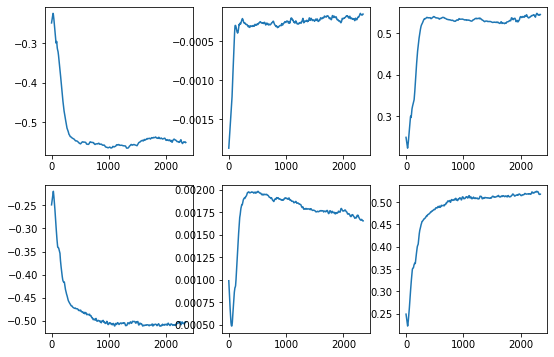

In [254]:
n_rows = len(w_mins)
xx = list(range(len(w_mins[0])))
fig, axes = plt.subplots(n_rows, 3, figsize=(9, n_rows * 3))

for idx in range(n_rows):
    axes[idx][0].plot(xx, w_mins[idx])
    axes[idx][1].plot(xx, w_means[idx])
    axes[idx][2].plot(xx, w_maxs[idx])

In [258]:
def get_grad_norms(model):
    norms_from = []
    norms_to = []
    for idx, layer in enumerate(model.layers):
        w = layer.weights
        g = layer.weights.grad
        n_l, d_l, n_h, d_h = ns[idx], ds[idx], ns[idx+1], ds[idx+1]

        w = w.reshape((n_l, d_l, n_h, d_h))
        w = w.permute((0, 2, 1, 3))

        g = g.reshape((n_l, d_l, n_h, d_h))
        g = g.permute((0, 2, 1, 3))
        g = g.reshape((n_l, -1))
        #
        g_norms_from = torch.linalg.norm(g, dim=1, ord=2)
        g = g.reshape(n_l, d_l, n_h, d_h)
        g = g.permute((1, 0, 2, 3))
        g = g.reshape((n_h, -1))
        g_norms_to= torch.linalg.norm(g, dim=1, ord=2)
        norms_from.append(g_norms_from)
        norms_to.append(g_norms_to)
    return norms_from, norms_to

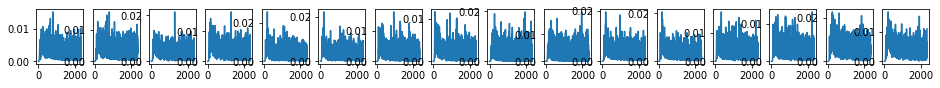

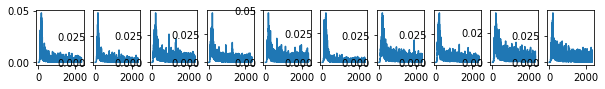

In [255]:
layer_idx = 0
GN = GN_TO

for layer_idx in range(len(GN[0])):
    gnorms = [gn[layer_idx] for gn in GN]
    gnorms = torch.stack(gnorms).cpu()
    #
    n_cols = gnorms.shape[1]
    fig, axes = plt.subplots(1, n_cols, figsize=(n_cols, 1))
    xx = list(range(gnorms.shape[0]))
    for col_idx in range(n_cols):
        axes[col_idx].plot(gnorms[:, col_idx])
    plt.show()

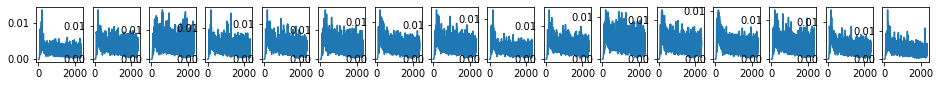

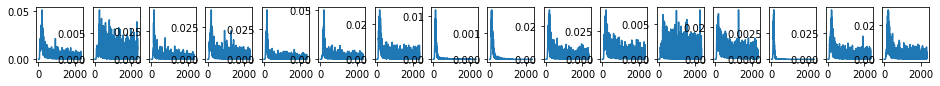

In [256]:
layer_idx = 0
GN = GN_FROM

for layer_idx in range(len(GN[0])):
    gnorms = [gn[layer_idx] for gn in GN]
    gnorms = torch.stack(gnorms).cpu()
    #
    n_cols = gnorms.shape[1]
    fig, axes = plt.subplots(1, n_cols, figsize=(n_cols, 1))
    xx = list(range(gnorms.shape[0]))
    for col_idx in range(n_cols):
        axes[col_idx].plot(gnorms[:, col_idx])
    plt.show()

# Visualize and Analyze

### Show parse tree and activations for individual samples

In [259]:
x, y = next(iter(dl_affnist_valid))

model.eval()
with torch.no_grad():
    u_h, CC, US, x_rec = model.forward_debug(x.to(device))
y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
y_pred = y_pred.detach().cpu().numpy()
#
US = [u.cpu().numpy() for u in US]
CS = [c.cpu().numpy() for c in CC]
#
Y_true = y.cpu().numpy()
Y_pred = y_pred

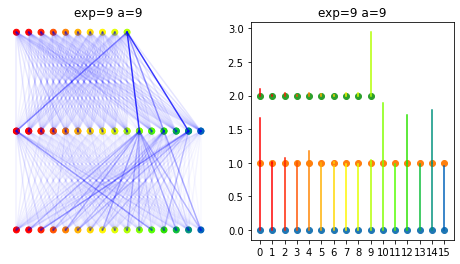

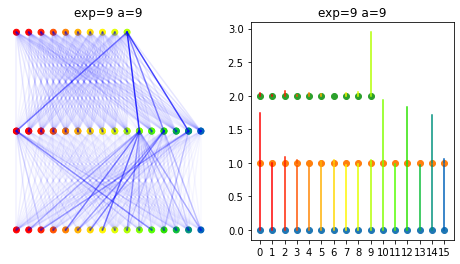

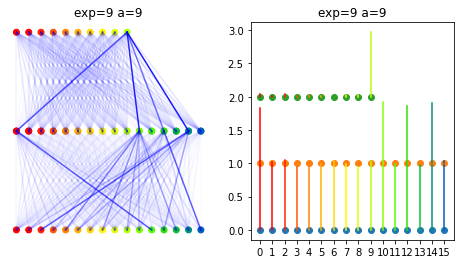

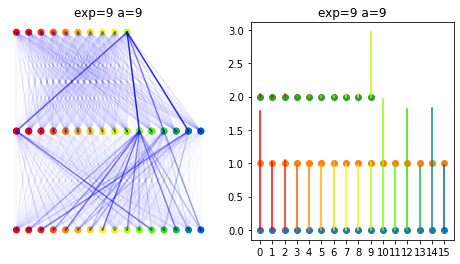

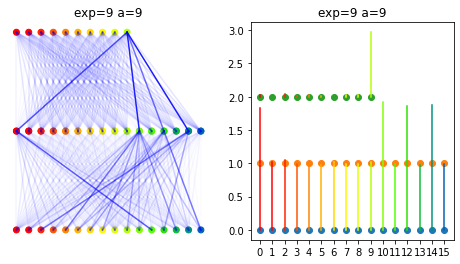

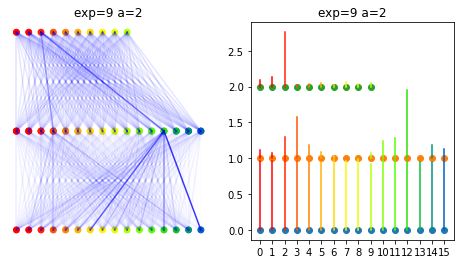

In [260]:
vis_class = 9
vis_max = 32
for idx in range(vis_max):
    if vis_class is not None and Y_true[idx] != vis_class:
        continue
    cs = [c[idx] for c in CS]
    us = [u[idx] for u in US]
    u_norms = [np.linalg.norm(u, axis=1) for u in us]
    
    # plot stuff
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    title = "exp={} a={}".format(y[idx], y_pred[idx])
    #
    plot_couplings(cs, title=title, ax=axes[0], show=False)
    plot_capsules(u_norms, title=title , ax=axes[1], show=False)
    plt.show()

# Statistics For Further Evaluation and Visualization

In [261]:
model.eval()

YY = []
CC = [[] for _ in range(len(ns) - 1)]
US = [[] for _ in range(len(ns))]


# use whole dataset
for x,y_true in dl_affnist_valid:
    x = x.to(device)
        
    with torch.no_grad():
        _, cc, us, _ = model.forward_debug(x.to(device))
        for idx in range(len(cc)):
            CC[idx].append(cc[idx].detach().cpu().numpy())
        for idx in range(len(us)):
            US[idx].append(us[idx].detach().cpu().numpy())
        YY.append(y_true.numpy())
        
# Dataset Labels
YY = np.concatenate(YY)

# Dataset Coupling Coefficient Matrices
CC = [np.concatenate(c) for c in CC]

# Dataset Capsules
US = [np.concatenate(u) for u in US]

### Mean parse tree and mean activation for dataset

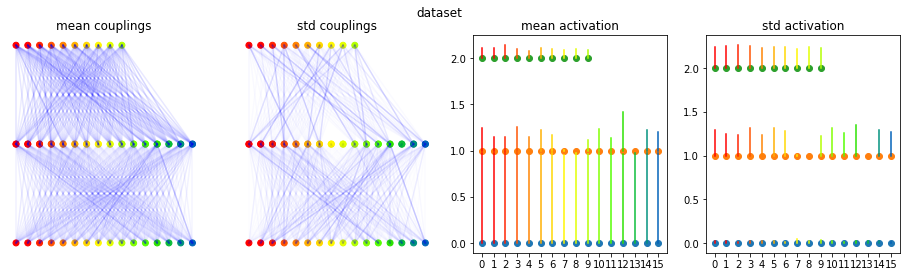

In [262]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
# Mean parse tree
cc_mean = [np.mean(c, axis=0) for c in CC]
cc_std = [np.std(c, axis=0) for c in CC]
plot_couplings(cc_mean, ax=axes[0], show=False, title="mean couplings")
plot_couplings(cc_std, ax=axes[1], show=False, title="std couplings")
    
# mean and std capsule activation
us_mean = [np.linalg.norm(u, axis=-1).mean(axis=0) for u in US]
us_std = [np.linalg.norm(u, axis=-1).std(axis=0) for u in US]
plot_capsules(us_mean, scale_factor=1, ax=axes[2], show=False, title="mean activation")
plot_capsules(us_std, scale_factor=1, ax=axes[3], show=False, title="std activation")
plt.suptitle("dataset")
plt.show()

### Parse tree from normalized Couplings

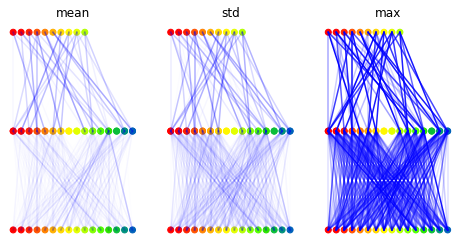

In [263]:
fig, axes = plt.subplots(1, 3, figsize=(4 * len(CC), 4))

CNS = [normalize_couplings(C) for C in CC]

CNS_MAN = [ma_couplings(C, pr) for C, pr in CNS]
CNS_MAX = [C.max(axis=0) for C, pr in CNS]
CNS_STD = [stda_couplings(C, pr) for C, pr in CNS]

plot_couplings(CNS_MAN, ax=axes[0], show=False, title="mean")
plot_couplings(CNS_STD, ax=axes[1], show=False, title="std")
plot_couplings(CNS_MAX, ax=axes[2], show=False, title="max")
plt.show()

### Classwise mean parse tree and mean activation

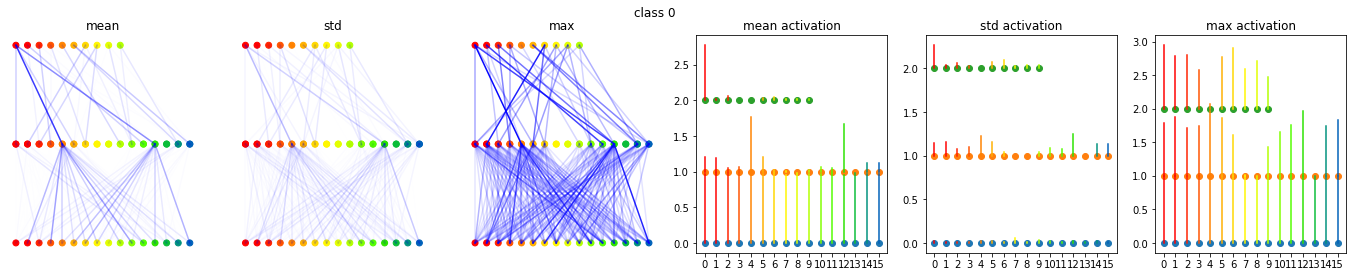

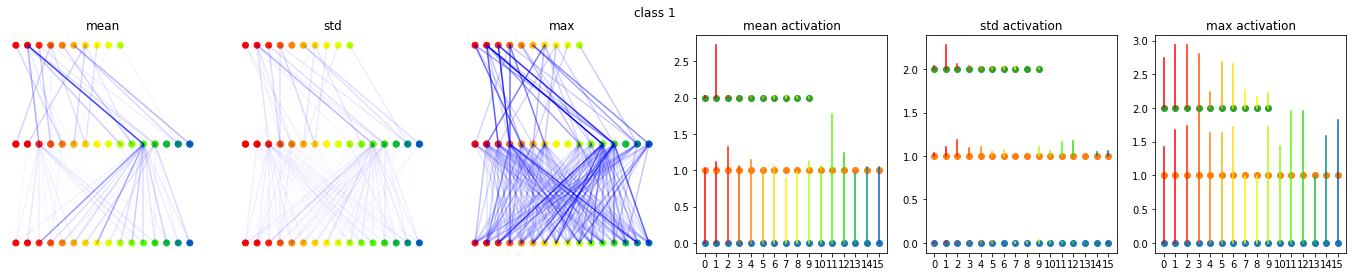

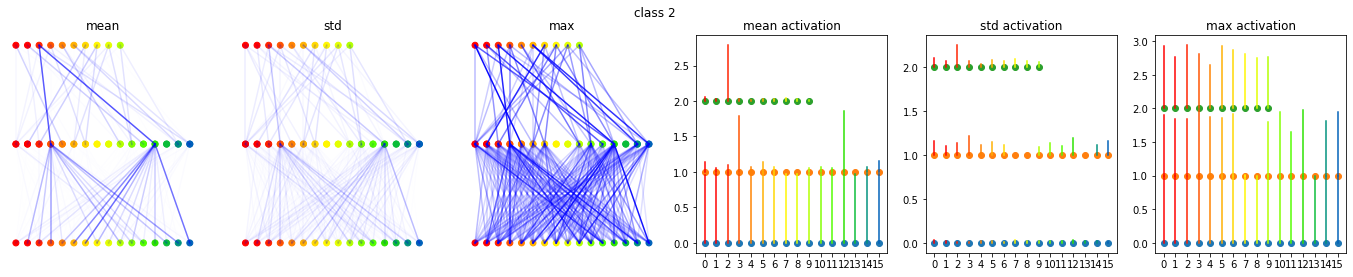

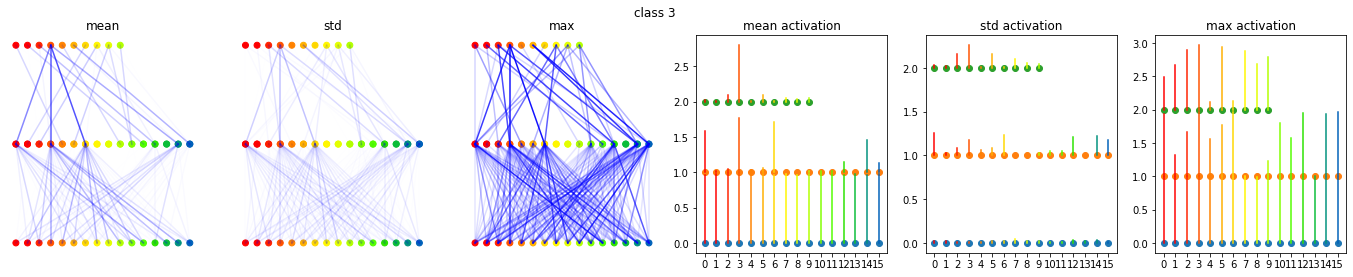

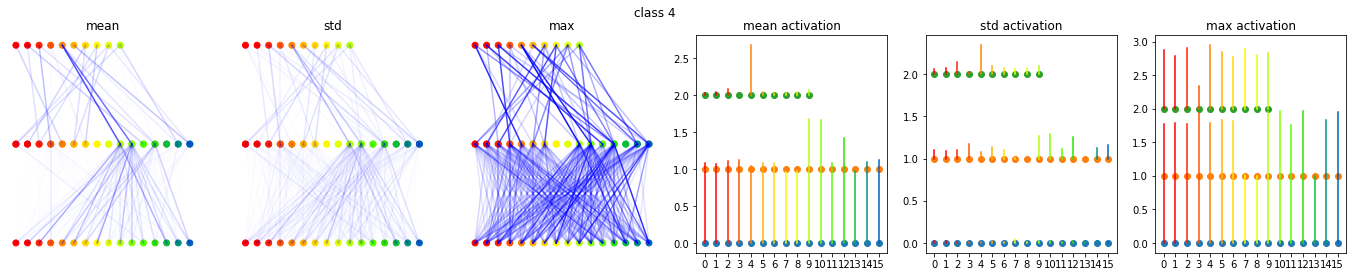

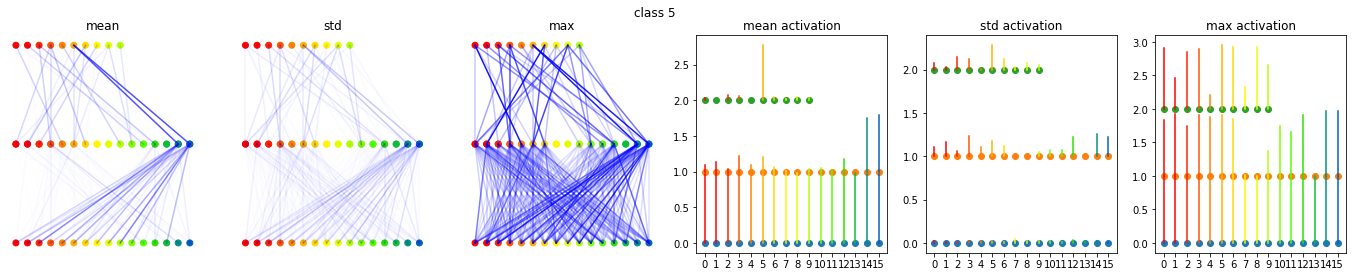

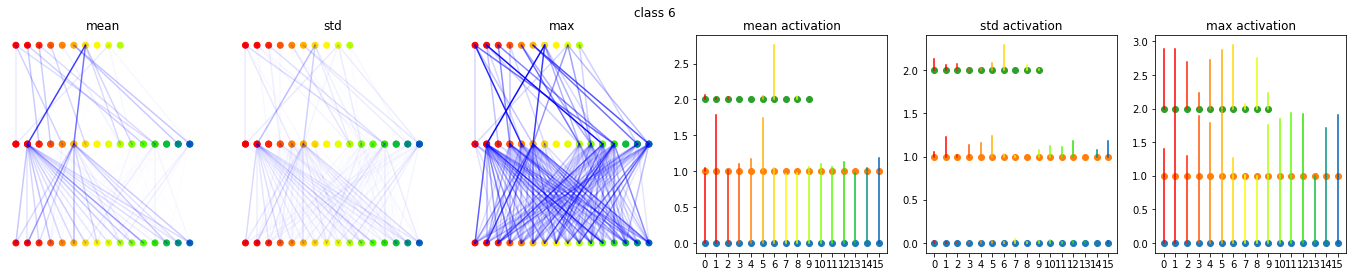

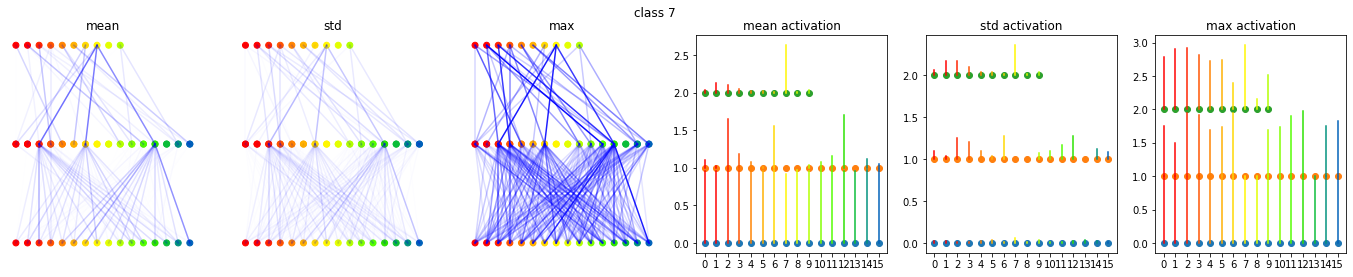

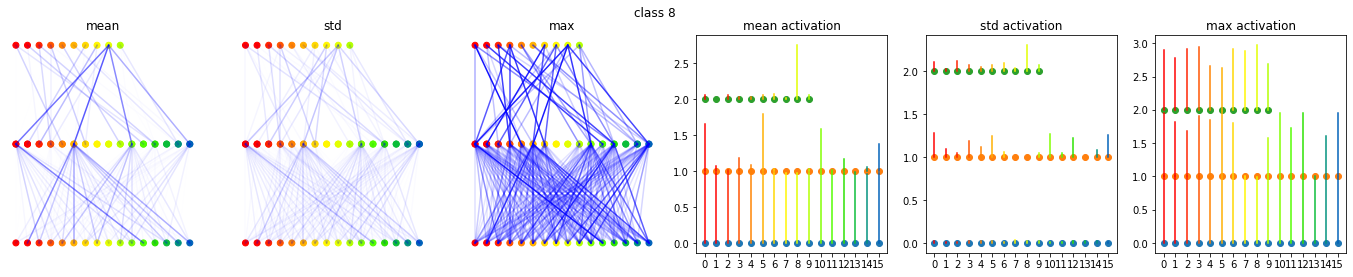

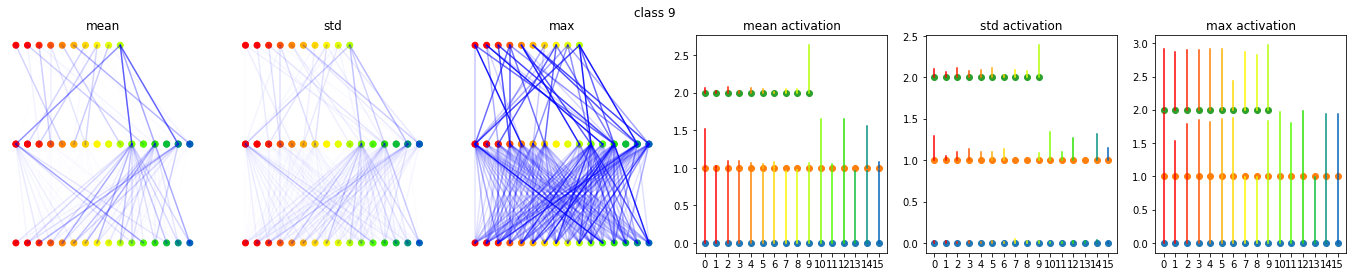

In [264]:
# mean and variance activation
for cls in range(10):
    idcs = np.where(YY == cls)[0]
    
    fig, axes = plt.subplots(1, 6, figsize=(24, 4))
    
    cc = [C[idcs] for C in CC]
    CNS = [normalize_couplings(C, eps_rate=0.5) for C in cc]
    
    CNS_MAN = [ma_couplings(C, pr) for C, pr in CNS]
    CNS_MAX = [C.max(axis=0) for C, pr in CNS]
    CNS_STD = [stda_couplings(C, pr) for C, pr in CNS]

    plot_couplings(CNS_MAN, ax=axes[0], show=False, title="mean")
    plot_couplings(CNS_STD, ax=axes[1], show=False, title="std")
    plot_couplings(CNS_MAX, ax=axes[2], show=False, title="max")
    
    # mean and std capsule activation
    us = [u[idcs] for u in US]
    us_mean = [np.linalg.norm(u, axis=-1).mean(axis=0) for u in us]
    us_std = [np.linalg.norm(u, axis=-1).std(axis=0) for u in us]
    us_max = [np.linalg.norm(u, axis=-1).max(axis=0) for u in us]
    
    plot_capsules(us_mean, scale_factor=1, ax=axes[3], show=False, title="mean activation")
    plot_capsules(us_std, scale_factor=1, ax=axes[4], show=False, title="std activation")
    plot_capsules(us_max, scale_factor=1, ax=axes[5], show=False, title="max activation")
    plt.suptitle("class {}".format(cls))
    plt.show()

# Coupling Death vs Alive

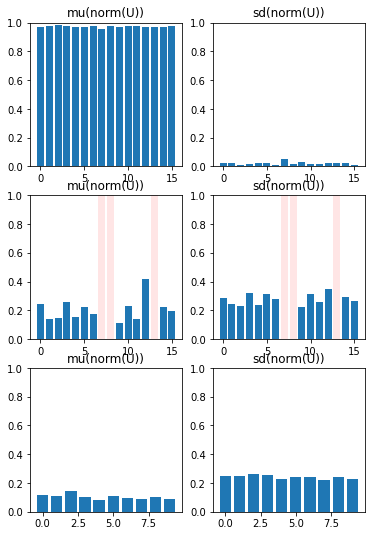

In [265]:
c_th_mu = 1e-2
c_th_sd = 1e-2

fig, axes = plt.subplots(len(US), 2, figsize=(6, 3 * len(US)))
#
US_alive = []
for idx in range(len(US)):
    U = US[idx]
    U_norm = np.linalg.norm(U, axis=2)
    U_norm_mu = U_norm.mean(axis=0)
    U_norm_sd = U_norm.std(axis=0)
    #
    U_dead = (U_norm_sd < 1e-2) * (U_norm_mu < 1e-2)
    #
    xx = range(len(U_norm_mu))
    axes[idx][0].set_title("mu(norm(U))")
    axes[idx][0].bar(xx, U_dead, color="red",alpha=0.1)
    axes[idx][0].bar(xx, U_norm_mu)
    axes[idx][0].set_ylim(0, 1)
    axes[idx][1].set_title("sd(norm(U))")
    axes[idx][1].bar(xx, U_norm_sd)
    axes[idx][1].bar(xx, U_dead, color="red",alpha=0.1)
    axes[idx][1].set_ylim(0, 1)
    U_alive = 1 - U_dead
    US_alive.append(U_alive)
plt.show()

# Metrics

### Vibrance

In [68]:
for U in US:
    pr = rate_dead_capsules_norm(U)
    print("#Permanently Dead: {:.3f}".format(pr.mean()))

#Permanently Dead: 0.000
#Permanently Dead: 0.812
#Permanently Dead: 0.000


In [69]:
for C in CC:
    pr = rate_inactive_capsules(C)
    print("Rate inactive capsules {:.3f}".format(pr.mean()))

Rate inactive capsules 0.063
Rate inactive capsules 0.564


In [70]:
# sanity check
for idx in range(len(CC)):
    C = CC[idx]
    U = US[idx]
    #
    rnd, rac, racnd =  get_vibrance(U, C)
    #
    print("rate alive: {:.3f} rate active {:.3f} rate active of alive {:.3f}".format(
        rnd, rac, racnd))

rate alive: 1.000 rate active 0.937 rate active of alive 0.937
rnd * racnd != rac: 0.185775 != 0.435775
rate alive: 0.188 rate active 0.436 rate active of alive 0.991


### Bonding

In [71]:
for idx in range(len(CC)):
    C = CC[idx]
    b = get_bonding(C)
    print_str = "bonding strength: {:.3f}"
    print(print_str.format(b))

bonding strength: 0.843
bonding strength: 0.577


### Dynamics

In [72]:
for idx in range(len(CC)):
    C = CC[idx]
    dyc = get_dynamics(C)
    #
    print("dynamics: {:.3f}".format(
          dyc))

dynamics: 0.086
dynamics: 0.129


### Correlation Capsule Activation and Max Coupling

In [73]:
for idx in range(len(CC)):
    U = US[idx]
    C = CC[idx]
    print("corr: {:.3f}".format(activation_coupling_corr(C, U)))

corr: 0.160
corr: 0.461


### metrics for whole dataset

In [74]:
vals = []
for idx in range(len(CC)):
    C = CC[idx]
    U = US[idx]
    #
    rnd, rac, racnd = get_vibrance(U, C)
    b = get_bonding(C)
    dyc = get_dynamics(C)
    cor = activation_coupling_corr(C, U)
    vals.append((idx,
                 rnd, rac, racnd,
                 b, dyc, cor))

rnd * racnd != rac: 0.185775 != 0.435775


In [ ]:
cols = ["layer",
        "alive rate", "active rate", "active of alive rate",
        "bonding str.", "dynamics", "cor"]
df = pd.DataFrame(data=vals, columns=cols)
df

### metrics for whole dataset, but classwise

In [ ]:

vals = []

#
for cls in range(10):
    idcs = np.where(YY == cls)[0]
    for idx in range(len(CC)):
        C = CC[idx][idcs]
        U = US[idx][idcs]
        #
        rnd, rac, racnd = get_vibrance(U, C)
        b = get_bonding(C)
        dyc = get_dynamics(C)
        cor = activation_coupling_corr(C, U)
        vals.append((cls, idx,
                     rnd, rac, racnd,
                     b, dyc, cor))

In [ ]:
cols = ["class", "layer",
        "alive rate", "active rate", "active of alive rate",
        "bonding str.", "dynamics", "cor"]
df = pd.DataFrame(data=vals, columns=cols)
#

In [ ]:
for idx in range(len(CC)):
    sdf = df[df["layer"] == idx].drop(columns=["layer"])
    print(sdf)

# Couplings Viszalizations

#### Couplings FROM DEAD Capsules

In [ ]:
for idx in range(len(CC)):
    C = CC[idx]
    Ul_alive = US_alive[idx]
    C = C[:,np.where(Ul_alive == False)[0],:]
    
    if len(C.flatten()) < 1:
        print("No dead capsules for layer {}".format(idx))
        continue
    
    C_mu = C.mean(axis=0)
    C_sd = C.std(axis=0)
    C_mx = C.max(axis=0)
    fig, axes = plt.subplots(1, 3, figsize=(33, 11))
    plot_mat2(C_mu, ax=axes[0], vmin=0, vmax=0.5)
    plot_mat2(C_sd, ax=axes[1], vmin=0, vmax=0.5)
    plot_mat2(C_mx, ax=axes[2], vmin=0, vmax=0.5)
plt.show()

#### Couplings FROM Alive Capsules

In [ ]:
for idx in range(len(CC)):
    C = CC[idx]
    Ul_alive = US_alive[idx]
    C = C[:,np.where(Ul_alive == True)[0],:]
    
    C_mu = C.mean(axis=0)
    C_sd = C.std(axis=0)
    C_mx = C.max(axis=0)
    fig, axes = plt.subplots(1, 3, figsize=(42, 14))
    plot_mat2(C_mu, ax=axes[0], vmin=0, vmax=0.5)
    plot_mat2(C_sd, ax=axes[1], vmin=0, vmax=0.5)
    plot_mat2(C_mx, ax=axes[2], vmin=0, vmax=0.5)
plt.show()

per sample count max coupling and use max to find out if coupling in general gets lower or just the average as they are loosly connected


### Couplings FROM ALIVE to DEAD

In [ ]:
for idx in range(len(CC)):
    C = CC[idx]
    Ul_alive = US_alive[idx]
    Uh_alive = US_alive[idx + 1]
    if (1 - Uh_alive).sum() < 1:
        print("{} No dead capsules for upper layer {}".format(idx ,idx + 1))
        continue
    
    
    C = C[:,np.where(Ul_alive == True)[0],:][:,:,np.where(Uh_alive == False)[0]]
    
    if len(C.flatten()) < 1:
        print("No dead capsules for layer {}".format(idx))
        continue
    
    C_mu = C.mean(axis=0)
    C_sd = C.std(axis=0)
    C_mx = C.max(axis=0)
    fig, axes = plt.subplots(1, 3, figsize=(33, 11))
    plot_mat2(C_mu, ax=axes[0], vmin=0, vmax=0.5)
    plot_mat2(C_sd, ax=axes[1], vmin=0, vmax=0.5)
    plot_mat2(C_mx, ax=axes[2], vmin=0, vmax=0.5)
plt.show()

### Couplings FROM ALIVE TO ALIVE

In [ ]:
for idx in range(len(CC)):
    C = CC[idx]
    Ul_alive = US_alive[idx]
    Uh_alive = US_alive[idx + 1]
    if (Uh_alive).sum() < 1:
        print("No dead capsules for upper layer {}".format(idx + 1))
        continue
    
    
    C = C[:,np.where(Ul_alive == True)[0],:][:,:,np.where(Uh_alive == True)[0]]
    
    if len(C.flatten()) < 1:
        print("No dead capsules for layer {}".format(idx))
        continue
    
    C_mu = C.mean(axis=0)
    C_sd = C.std(axis=0)
    C_mx = C.max(axis=0)
    fig, axes = plt.subplots(1, 3, figsize=(33, 11))
    plot_mat2(C_mu, ax=axes[0], vmin=0, vmax=0.5)
    plot_mat2(C_sd, ax=axes[1], vmin=0, vmax=0.5)
    plot_mat2(C_mx, ax=axes[2], vmin=0, vmax=0.5)
plt.show()

# CNN Only Baseline

In [ ]:
"""
epochs = 050, acc = 98,0, 73.0
epochs = 101, acc = 98.5, 74.1
epochs = 201, acc = 
"""

In [ ]:
model = CustomBB(ch_in=1, n_classes=10)
#
model = model.to(device)
#backbone
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay=2e-5)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.96)
#
criterion = nn.CrossEntropyLoss()

In [ ]:
print(count_parameters(model))

In [ ]:
num_epochs = 101
#
for epoch_idx in range(num_epochs):
    # ####################
    # TRAIN
    # ####################
    model.train()
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_mnist_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    
    for x,y_true in pbar:
        x = x.to(device)
        y_true = y_true.to(device)
        optimizer.zero_grad()
        
        logits = model.forward(x)
        loss = criterion(logits, y_true)

        loss.backward()
        
        optimizer.step()
        
        y_pred = torch.argmax(logits, dim=1)
        acc = (y_true == y_pred).sum() / y_true.shape[0]
        
        pbar.set_postfix(
                {'loss': loss.item(),
                 'acc': acc.item()
                 }
        )
    lr_scheduler.step()
    #
    # ####################
    # VALID
    # ####################
    if epoch_idx % 5 != 0:
        continue
    
    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_mnist_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            logits = model.forward(x)
            
            y_pred = torch.argmax(logits, dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   mnist acc_valid: {:.3f}".format(total_correct / total))

    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_affnist_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            logits = model.forward(x)
            
            y_pred = torch.argmax(logits, dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   affnist acc_valid: {:.3f}".format(total_correct / total))